In [13]:
import pandas as pd
import numpy as np
# importing or loading the dataset
dataset = pd.read_csv('./data/dataset_for_PCA.csv')
dataset = dataset[['R_0 3', 'population', 'travel_time_S_Google', 'Total_route_length_m', 'travel_time_S', 'DegreeCentrality', 'EigenvectorCentrality', 'PageRank', 'WeightedPersonalizedPagerank', 'Hubs', 'BetweennessCentrality', 'WeightedPersonalizedPagerankWuhanOutflow', 'WeightedPersonalizedPagerankBeijingInflow']]  
dataset = dataset.rename(columns={'R_0 3': 'R_0_3'})

# rename columns of the dataset to make them more readable
dataset = dataset.rename(columns={
    'R_0 3': 'COVID-19 reproduction number',
    'population': 'Population size',
    'travel_time_S_Google': 'Travel time',
    'Total_route_length_m': 'Total route length (meters)',
    'travel_time_S': 'Travel time from OSM',
    'DegreeCentrality': 'Degree centrality',
    'EigenvectorCentrality': 'Eigenvector centrality',
    'PageRank': 'PageRank',
    'WeightedPersonalizedPagerank': 'Weighted personalized PageRank',
    'Hubs': 'Hubs',
    'BetweennessCentrality': 'Betweenness centrality',
    'WeightedPersonalizedPagerankWuhanOutflow': 'Weighted personalized PageRank (Wuhan outflow)',
    'WeightedPersonalizedPagerankBeijingInflow': 'Weighted personalized PageRank (Beijing inflow)'
})

to_drop = ['Total route length (meters)','Travel time from OSM', 'Eigenvector centrality', 'Weighted personalized PageRank', 'Hubs']
dataset_reduced = dataset.drop(to_drop, axis=1)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
#
# Load the Dataset

X = dataset_reduced.iloc[:, 1:]
target = np.array(dataset_reduced['R_0_3'])

#
# Create Training and Test Split
#
X_train, X_test, y_train, y_test = train_test_split(X, target, random_state=42, test_size=0.1)
#
# Standardize the dataset
#
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)
#
# Hyperparameters for GradientBoostingRegressor
#
gbr_params = {'n_estimators': 1000,
          'max_depth': 3,
          'min_samples_split': 5,
          'learning_rate': 0.01,
          'loss': 'squared_error'} # loss function to optimize. The least squares function is used in this case however, there are many other options 
#
# Create an instance of gradient boosting regressor
#
gbr = GradientBoostingRegressor(**gbr_params)
#
# Fit the model
#
gbr.fit(X_train_std, y_train)
#
# Print Coefficient of determination R^2
#
print("Model Accuracy: %.3f" % gbr.score(X_test_std, y_test))
#
# Create the mean squared error
#
mse = mean_squared_error(y_test, gbr.predict(X_test_std))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

Model Accuracy: 0.882
The mean squared error (MSE) on test set: 10.0278


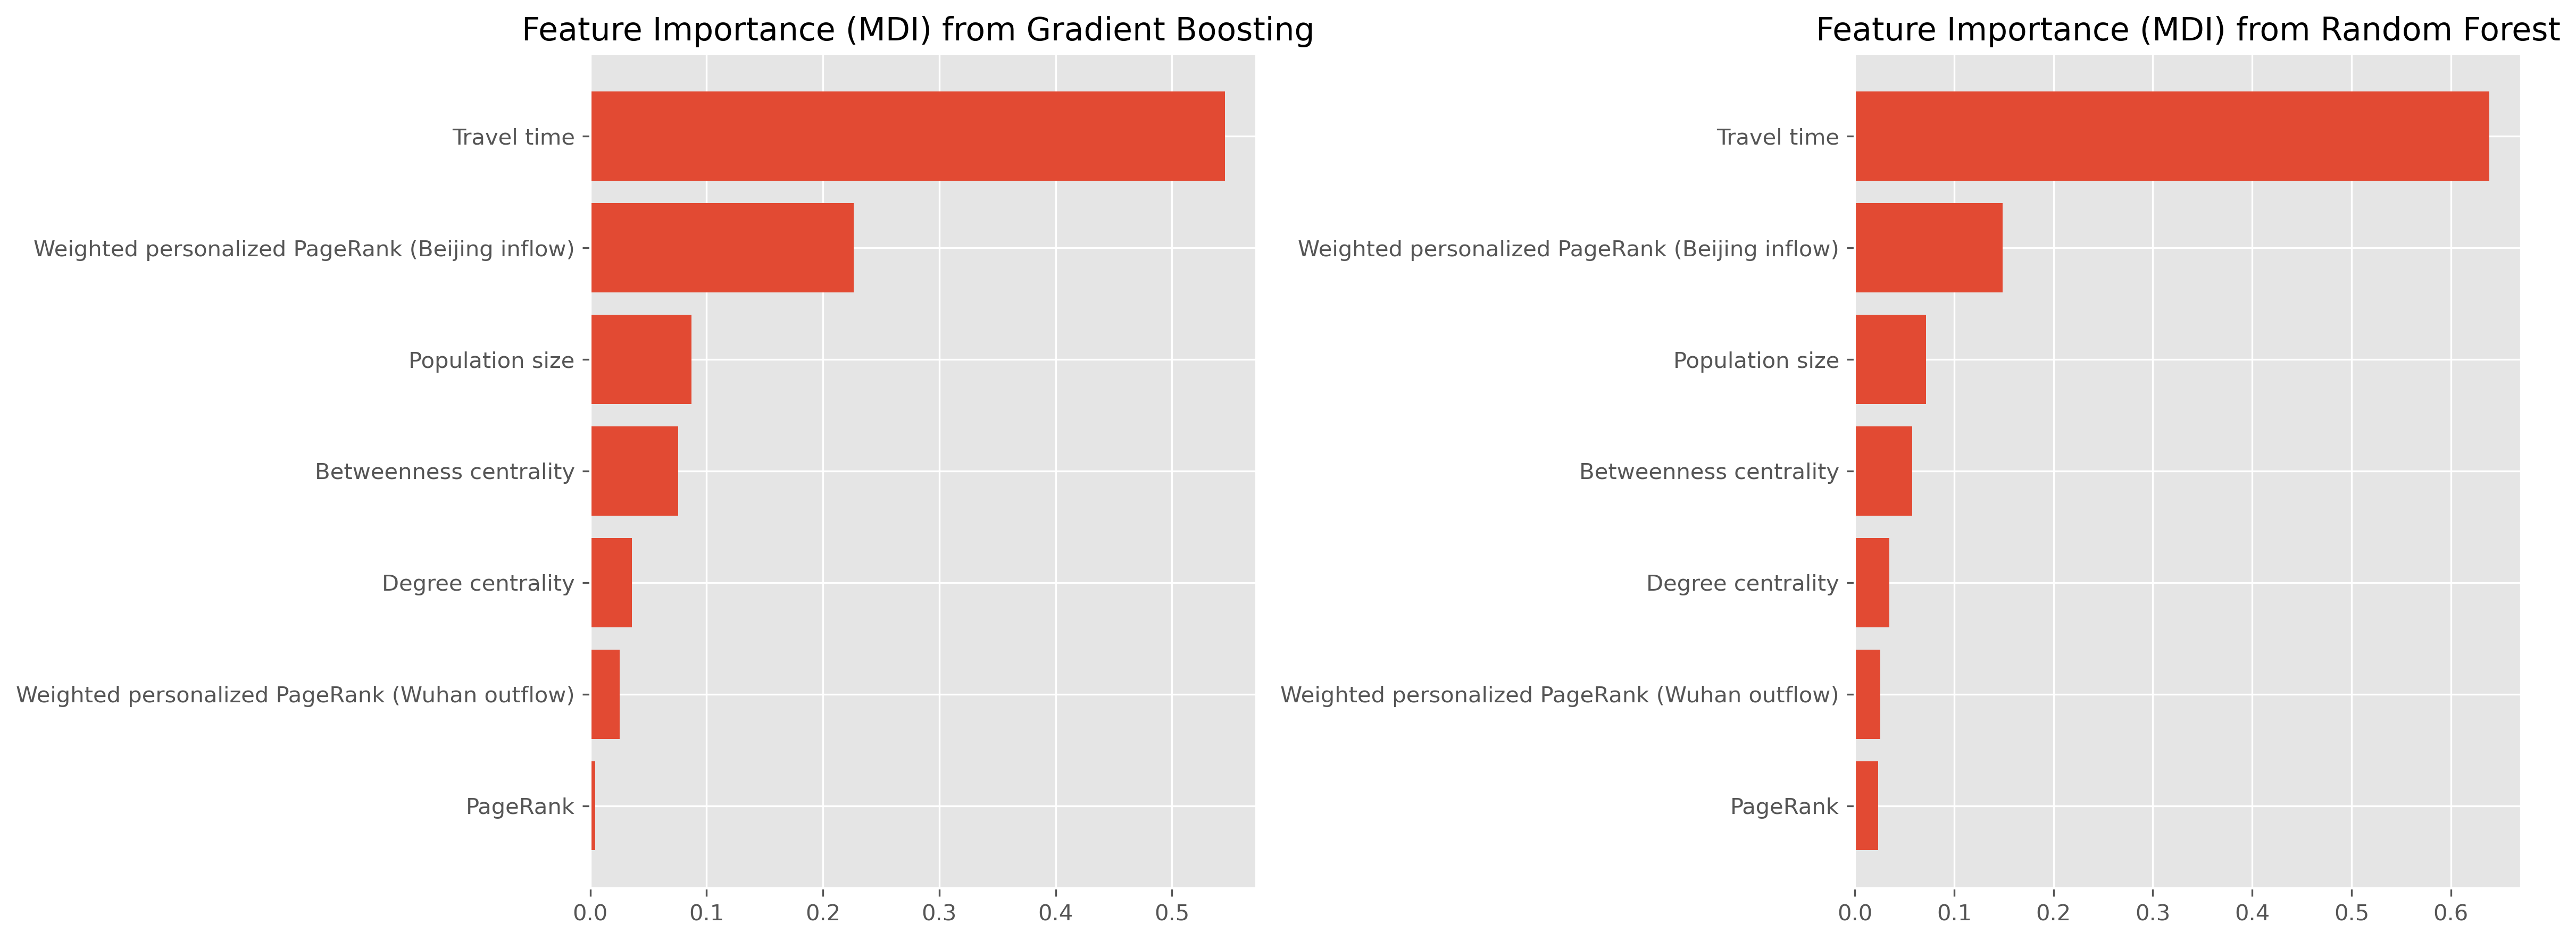

In [10]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 14] #[W,H]
plt.rcParams['figure.dpi'] = 300
plt.style.use('ggplot') 
from sklearn.inspection import permutation_importance

#from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
#from sklearn.linear_model import LinearRegression
#from sklearn.ensemble import VotingRegressor
#
# Get Feature importance data using feature_importances_ attribute
#
feature_importance = gbr.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

#****************************************************
# Build feature/target arrays
X_rf, y_rf = dataset_reduced.drop('R_0_3', axis=1), dataset_reduced['R_0_3']

# Generate train/test sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=.3, random_state=1121218)


# Init, fit, score
forest = RandomForestRegressor()
_ = forest.fit(X_train_rf, y_train_rf)

sc = StandardScaler()
X_train_std_rf = sc.fit_transform(X_train_rf)
X_test_std_rf = sc.transform(X_test_rf)
#
# Get Feature importance data using feature_importances_ attribute
#
feature_importance_rf = _.feature_importances_
sorted_idx_rf = np.argsort(feature_importance_rf)
pos_rf = np.arange(sorted_idx_rf.shape[0]) + .5

#****************************************************

fig = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title("Feature Importance (MDI) from Gradient Boosting ")

plt.subplot(1, 2, 2)
plt.barh(pos_rf, feature_importance_rf[sorted_idx_rf], align='center')
plt.yticks(pos_rf, np.array(X_rf.columns)[sorted_idx_rf])
plt.title('Feature Importance (MDI) from Random Forest')



fig.tight_layout()
plt.savefig('Feature_Importance_new.pdf', 
            metadata = {'Creator': 'Reju Sam John', 'Author': 'Reju', 'Title': 'internal epidemic dynamics Wuhan Feature Importance'},
           bbox_inches = 'tight', pad_inches = 0.2)
plt.show()



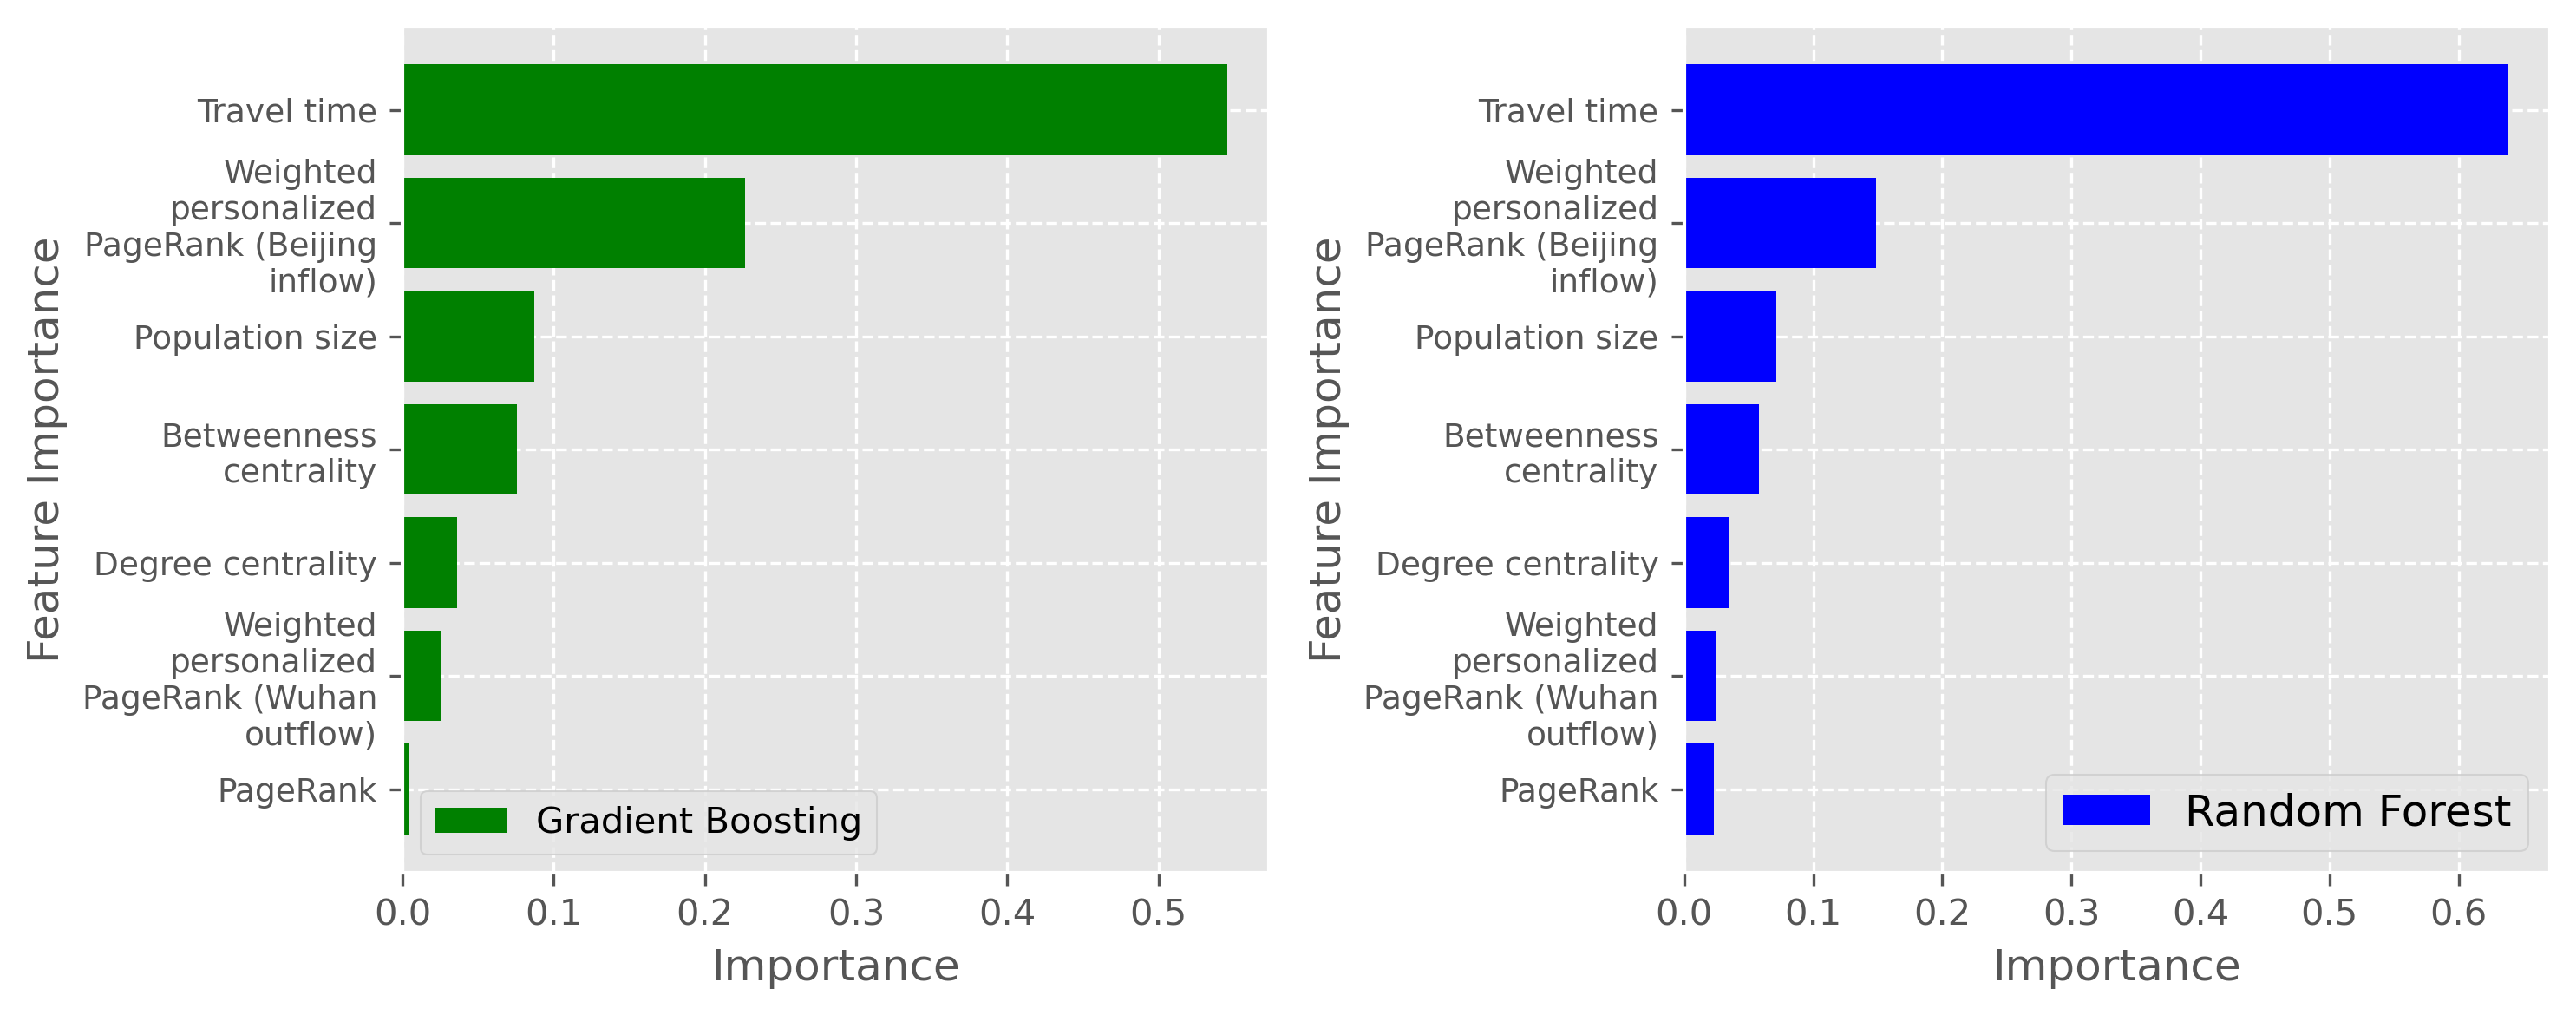

In [35]:
import textwrap

fig = plt.figure(figsize=(10, 4))

# Subplot 1: Gradient Boosting
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center", color="green")
yticks = np.array(X.columns)[sorted_idx]
yticks = [ '\n'.join(textwrap.wrap(label, 20)) for label in yticks ]
plt.yticks(pos, yticks, fontsize=9)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature Importance", fontsize=12)
#plt.title("Feature Importance (MDI) from Gradient Boosting", fontsize=14) Mean Decrease in Impurity (MDI)
plt.grid(True, linestyle='--')
# Add legend
plt.legend(['Gradient Boosting'])

# Subplot 2: Random Forest
plt.subplot(1, 2, 2)
plt.barh(pos_rf, feature_importance_rf[sorted_idx_rf], align='center', color="blue")
yticks_rf = np.array(X_rf.columns)[sorted_idx_rf]
yticks_rf = [ '\n'.join(textwrap.wrap(label, 20)) for label in yticks_rf ]
plt.yticks(pos_rf, yticks_rf, fontsize=9)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature Importance", fontsize=12)
#plt.title("Feature Importance (MDI) from Random Forest", fontsize=14) Mean Decrease in Impurity (MDI)
plt.grid(True, linestyle='--')

# Add legend
plt.legend(["Random Forest"], fontsize=12)

# Adjust layout and save plot
fig.tight_layout()
plt.savefig('Feature_Importance_new.pdf', 
            metadata={'Creator': 'Reju Sam John', 'Author': 'Reju', 'Title': 'internal epidemic dynamics Wuhan Feature Importance'},
            bbox_inches='tight', pad_inches=0.2)

plt.show()



In [ ]:
# matrix = dataset.corr().abs()
# mask = np.triu(np.ones_like(matrix, dtype=bool))
# reduced_matrix = matrix.mask(mask)
# # set a threshold to decide whether to drop a feature or not.
# # Find columns that meet the 0.90 threshold
# to_drop = [c for c in reduced_matrix.columns if any(reduced_matrix[c] > 0.9)]
# to_drop